## ***1- Importation des librairies***
---

In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data= pd.read_fwf('/content/drive/MyDrive/Data_M/africain_hate_msg.txt', names= ['tweet'])

In [ ]:
#récupérer les tweets brut
data_brut= '/content/drive/MyDrive/Data_M/africain_hate_msg.txt'
with open(data_brut, "r") as file:
    lines_brut = file.readlines()

In [ ]:
# transformer en dataframe
data = pd.DataFrame(lines_brut, columns = ['tweet'])

In [ ]:
data.head(20)

,tweet
0,NoRt
1,y’en a qui doivent prier à la mosquée à côté d...
2,A chaque fois vous dites on reçoit des dm ou i...
3,En tant que vendeur je souffre frr des renoi q...
4,"Un sale type est un sale type. Arabe, Noir, Ja..."
5,Ta mis un singe parce que c 'est un noir? Sale...
6,sale noir*
7,Faustine madame la raciste dans l'émission de ...
8,gaston lagaffe au bureau : dsl pour la ptite g...
9,Ça ne me viendrait pas à l’esprit de dire à Ze...


## ***2- Importation des données encodées avec le transformer bertweetfr***
---

In [ ]:
vec= np.load('/content/drive/MyDrive/Data_M/hate_encoded_msg.npy')

In [ ]:
vec.shape

(3054, 768)

## ***3- Entrainement pour detection d'anomalie avec IF***
---

In [ ]:
%%time
from sklearn.ensemble import IsolationForest
# definir le modèle ainsi que ses paramètres
clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0, contamination=0.1)
# Entrainer le modèle
clf.fit(vec)

CPU times: user 4.19 s, sys: 260 ms, total: 4.45 s
Wall time: 3.63 s


## ***4- Prédiction***
---

In [ ]:
%%time
# faire des prédictions sur nos données
pred = clf.predict(vec)

CPU times: user 746 ms, sys: 0 ns, total: 746 ms
Wall time: 744 ms


In [ ]:
# rajouter une colonne dans le dataframe
data['pred']= pred

## ***5- Identifier les outiliers***
---

In [ ]:
#localiser les outliers dans le dataframe
outliers=data['tweet'].loc[data['pred']==-1]
outlier_index=list(outliers.index)
data['pred'].value_counts()

 1    2748
-1     306
Name: pred, dtype: int64

In [ ]:
outliers.head(20)

0                                                NoRt\n
6                                          sale noir*\n
8     gaston lagaffe au bureau : dsl pour la ptite g...
22    Ancelotti nous insultes de sale noir là je voi...
23                                  dégages sale noir\n
27    Suarez va insulter Lemar de sale noir pour rev...
35                                  Chouine sale noir\n
42                                    Sale chat noir.\n
52                                        vieux negre\n
54    Meme lui il est étonné du sale qu’il a fait su...
65    Pq t’as supprimé l’autre réponse j’allais t’in...
69                                 négroïde quantique\n
71    Dernière cette page y’a un juif negroide y’a P...
72    Un congoïde assimilé dans la TL pour séduire M...
75    Femmelettes ouaisHomolalie sous le (bon gros j...
83                                         Incroyable\n
84    Nan il ce fait washer tt le match peine perdu ...
90    Twitter rachèté, ouaii !BOUGNOULENEGRONAZI

In [ ]:
data.head(20)

,tweet,pred
0,Sale noir vas\n,1
1,Ya quoi sale noir\n,1
2,Jsui mort\n,1
3,Bah le babouin\n,1
4,je préfère banania\n,1
5,Negre de maison\n,1
6,c toi sale noir\n,1
7,Nègre brésilien triangulaire\n,1
8,J’ai menti ?\n,1
9,oh ptn sale noir\n,1


## ***6- Visulaliser les outliers***
---

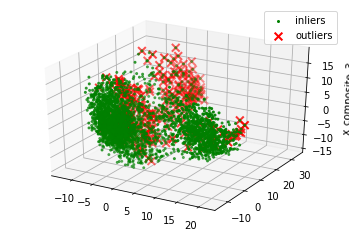

CPU times: user 661 ms, sys: 323 ms, total: 983 ms
Wall time: 1.13 s


In [ ]:
# Visulaliser les outliers 3 dimensions
%%time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(vec)
X_reduce = pca.fit_transform(X)

fig = plt.figure()
figsize=(12, 12,12)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

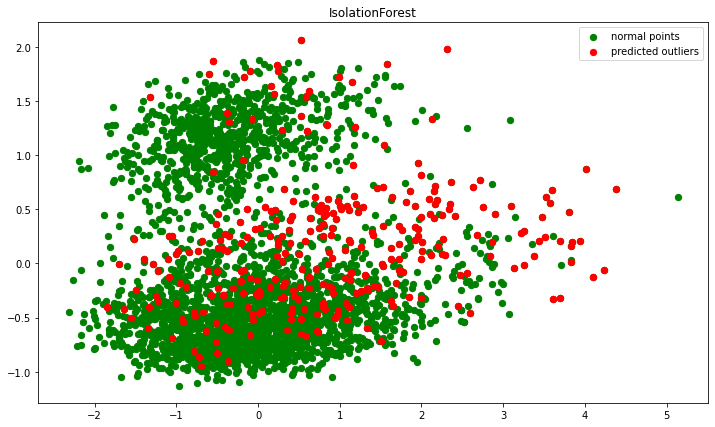

CPU times: user 521 ms, sys: 185 ms, total: 706 ms
Wall time: 697 ms


In [ ]:
# Visulaliser les outliers 2 dimensions
%%time
pca = PCA(2)
pca.fit(vec)


res=pd.DataFrame(pca.transform(vec))

Z = np.array(res)
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.title("IsolationForest")
#plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='green',
                 s=40,label="normal points")

b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

On remarque que les outliers sont des tweets  contenant les mots dollars , des mots en coréen

## ***7- Enregistrement des clusters affinés***
---

In [ ]:
with open("outliers_data_africain_bert.txt", 'w') as f:
  for line in outliers:
    f.write(line)